In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from scipy.special import expit
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import mode
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
import wandb
from sklearn.model_selection import KFold


In [4]:
class MyDecisionTreeRegressor:
    def __init__(self, **kwargs):
        self.model = DecisionTreeRegressor(**kwargs)
        self.confidence_metric = None

    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def compute_metrics(self,X_val,y_val):
        predictions_val = self.model.predict(X_val)
        mse_val = mean_squared_error(y_val, predictions_val)
        # Confidence metric is the inverse of MSE on validation data (higher confidence for lower MSE)
        self.confidence_metric = 1 / (1 + mse_val)
        confidence_metric = self.confidence_metric
        return mse_val,confidence_metric

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions
    
    def plot_predictions_vs_actual(self,predictions, actual, title="Predictions vs Actual"):
        plt.figure(figsize=(10, 6))
        plt.plot(predictions, label='Predictions', marker='o')
        plt.plot(actual, label='Actual', marker='x')
        plt.title(title)
        plt.xlabel('Sample Index')
        plt.ylabel('Values')
        plt.legend()
        plt.show()



In [5]:
class GBT_Regressor:
    def __init__ (self, num_trees, learning_rate):
        self.num_trees = num_trees
        self.learning_rate = learning_rate
        self.models = []
        self.base_model_value = 0
    
    def fit(self, X_train, y_train):
        predictions  = np.ones(X_train.shape[0])*np.mean(y_train)
        self.base_model_value = np.mean(y_train)
        
        for i in range(self.num_trees):
            residuals = y_train - predictions
            dt = MyDecisionTreeRegressor()
            dt.fit(X_train, residuals)
            new_predictions = self.learning_rate*dt.predict(X_train) + predictions
            predictions = new_predictions
            self.models.append(dt)
 
    def predict(self, X):
        # Make predictions by summing the predictions from each tree
        predictions = np.sum([self.learning_rate * model.predict(X) for model in self.models], axis=0)
        return self.base_model_value+predictions[:,0]


In [6]:
dataset_path = './HousingData.csv'
df = pd.read_csv(dataset_path)

Y = df.iloc[:, -1].values.reshape(-1, 1)
X = df.iloc[:, :-1].values

# finding nan values in the data and replacing by 0
X = np.nan_to_num(X, nan=0)
mean_values = np.mean(X, axis=0)
std_dev_values = np.std(X, axis=0)

# Perform Z-score normalization
X = (X - mean_values) / std_dev_values

print('number of samples  : ',X.shape[0])
print('number of features : ',X.shape[1])

f=0.8 # train fraction
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=1-f, random_state=42)
# then splitting the remaining data into val and test (50% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


number of samples  :  506
number of features :  13


In [7]:
gbt_regressor = GBT_Regressor(num_trees=100,learning_rate=0.15)
gbt_regressor.fit(X_train, y_train)

In [8]:
predicted = gbt_regressor.predict(X_test)
print('predicted : ',np.round(predicted,2))
print('ground truth : ',np.squeeze(y_test))

predicted :  [20.88 23.14 29.33 25.14 42.64 18.48 22.95 17.36 20.88 24.33 43.1  23.08
 14.79 29.74 22.48 16.7  10.7  12.95  9.86 21.74 19.38 29.9  14.75 27.69
 22.   14.14 24.76 11.9  25.38 20.84 26.36 15.26 27.45 22.74 18.85 27.45
 20.89 13.16 19.34 15.51 20.79  8.46 16.35 17.64 19.3   8.3  14.14 14.49
  8.3  12.   50.  ]
ground truth :  [23.1 24.8 31.5 24.2 50.  19.7 23.2 15.1 21.5 23.6 50.  23.8 17.9 29.
 20.1 16.1  7.  20.8  7.  20.3 22.5 26.5 12.7 30.8 22.6  9.6 29.8 20.6
 23.4 16.8 19.4 18.9 21.4 21.2 21.7 24.1 20.  10.9 20.  19.4 18.8 10.4
 19.1 14.  17.4 10.8 14.9 14.1  9.7 13.8 48.5]


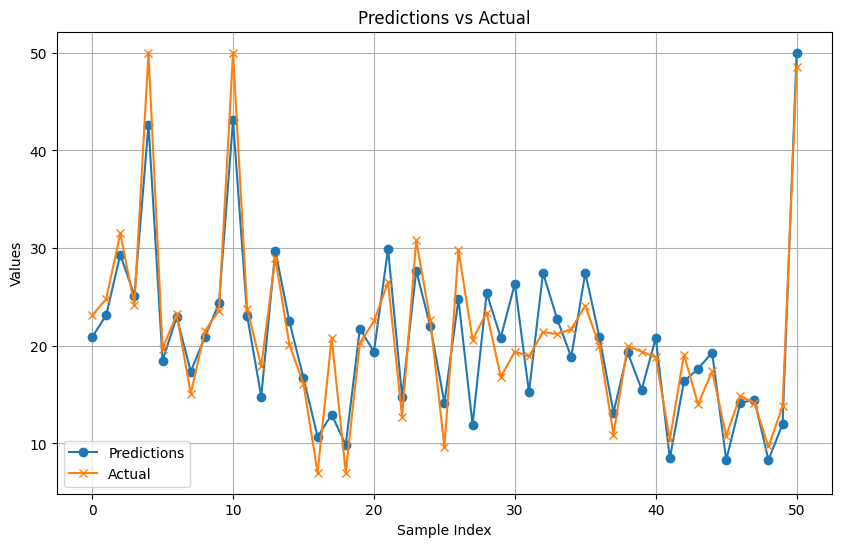

MSE  :  11.582796699164192
Root MSE  :  3.403350804598931
T-squared  :  0.8603705797922199


In [9]:
plt.figure(figsize=(10, 6))
plt.plot(predicted, label='Predictions', marker='o')
plt.plot(y_test, label='Actual', marker='x')
plt.title("Predictions vs Actual")
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()


mse = mean_squared_error(y_test,predicted)
rmse = np.sqrt(mse)
r_squared = r2_score(y_pred=predicted,y_true=y_test)
print('MSE  : ',mse)
print('Root MSE  : ',rmse)
print('T-squared  : ',r_squared)


### Plotting Training time and MSE vs number of estimators

In [10]:
mse_list = []
inf_time = []
num_est = []

for n in range(100):
    t1 = time.time()
    gbt_regressor = GBT_Regressor(num_trees=n+5,learning_rate=0.15)
    gbt_regressor.fit(X_train, y_train)
    predicted = gbt_regressor.predict(X_test)
    t2 = time.time()
    mse = mean_squared_error(y_test,predicted)
    num_est.append(n+5)
    mse_list.append(mse)
    inf_time.append(t2-t1)
    


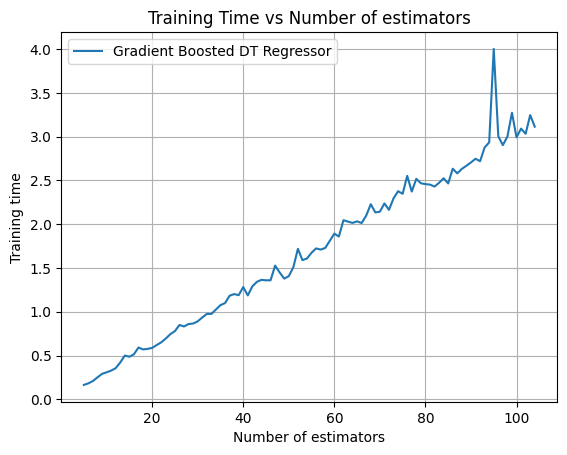

In [11]:
plt.plot(num_est, inf_time, label='Gradient Boosted DT Regressor')
plt.xlabel('Number of estimators')
plt.ylabel('Training time')
plt.legend()
plt.grid()
plt.title('Training Time vs Number of estimators')
plt.show()

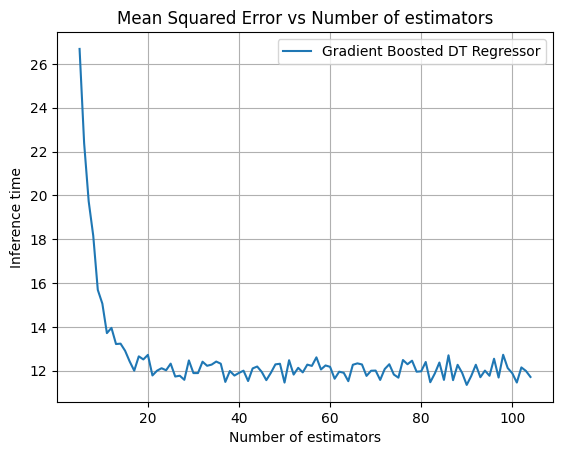

In [12]:
plt.plot(num_est, mse_list, label='Gradient Boosted DT Regressor')
plt.xlabel('Number of estimators')
plt.ylabel('Inference time')
plt.legend()
plt.grid()
plt.title('Mean Squared Error vs Number of estimators')
plt.show()